In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

# 导入TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

print(f"TensorFlow版本: {tf.__version__}")
print(f"Keras版本: {keras.__version__}")

# 设置中文字体和图形样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rc('font',family='SimHei')

TensorFlow版本: 2.10.0
Keras版本: 2.10.0


In [11]:
iris = fetch_ucirepo(id=53)
X = iris.data.features
y = iris.data.targets


print(f"特征形状: {X.shape}")
print(f"目标形状: {y.shape}")
print(f"\n特征名称: {list(X.columns)}")
print(f"目标变量: {list(y.columns)}")
print(f"\n目标变量唯一值: {y['class'].unique()}")
print(f"\n前5行数据:")
print(pd.concat([X.head(), y.head()], axis=1))


print("1. 数据类型:")
print(X.dtypes)

print("\n2. 缺失值检查:")
print(X.isnull().sum())

print("\n3. 基本统计信息:")
print(X.describe())


特征形状: (150, 4)
目标形状: (150, 1)

特征名称: ['sepal length', 'sepal width', 'petal length', 'petal width']
目标变量: ['class']

目标变量唯一值: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']

前5行数据:
   sepal length  sepal width  petal length  petal width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa
1. 数据类型:
sepal length    float64
sepal width     float64
petal length    float64
petal width     float64
dtype: object

2. 缺失值检查:
sepal length    0
sepal width     0
petal length    0
petal width     0
dtype: int64

3. 基本统计信息:
       sepal length  sepal width  petal length  petal width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.1

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 处理缺失值（如果有）
if X.isnull().sum().sum() > 0:
    print("发现缺失值，使用均值填充...")
    X = X.fillna(X.mean())
else:
    print("没有缺失值。")

# 编码目标变量
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y['class'])
class_names = label_encoder.classes_
num_classes = len(class_names)

print(f"\n目标变量编码映射:")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"\n数据集划分:")
print(f"训练集: {X_train.shape}, 测试集: {X_test.shape}")
print(f"训练集类别分布: {np.bincount(y_train)}")
print(f"测试集类别分布: {np.bincount(y_test)}")

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 为TensorFlow模型准备数据（one-hot编码）
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

没有缺失值。

目标变量编码映射:
  0: Iris-setosa
  1: Iris-versicolor
  2: Iris-virginica

数据集划分:
训练集: (105, 4), 测试集: (45, 4)
训练集类别分布: [35 35 35]
测试集类别分布: [15 15 15]


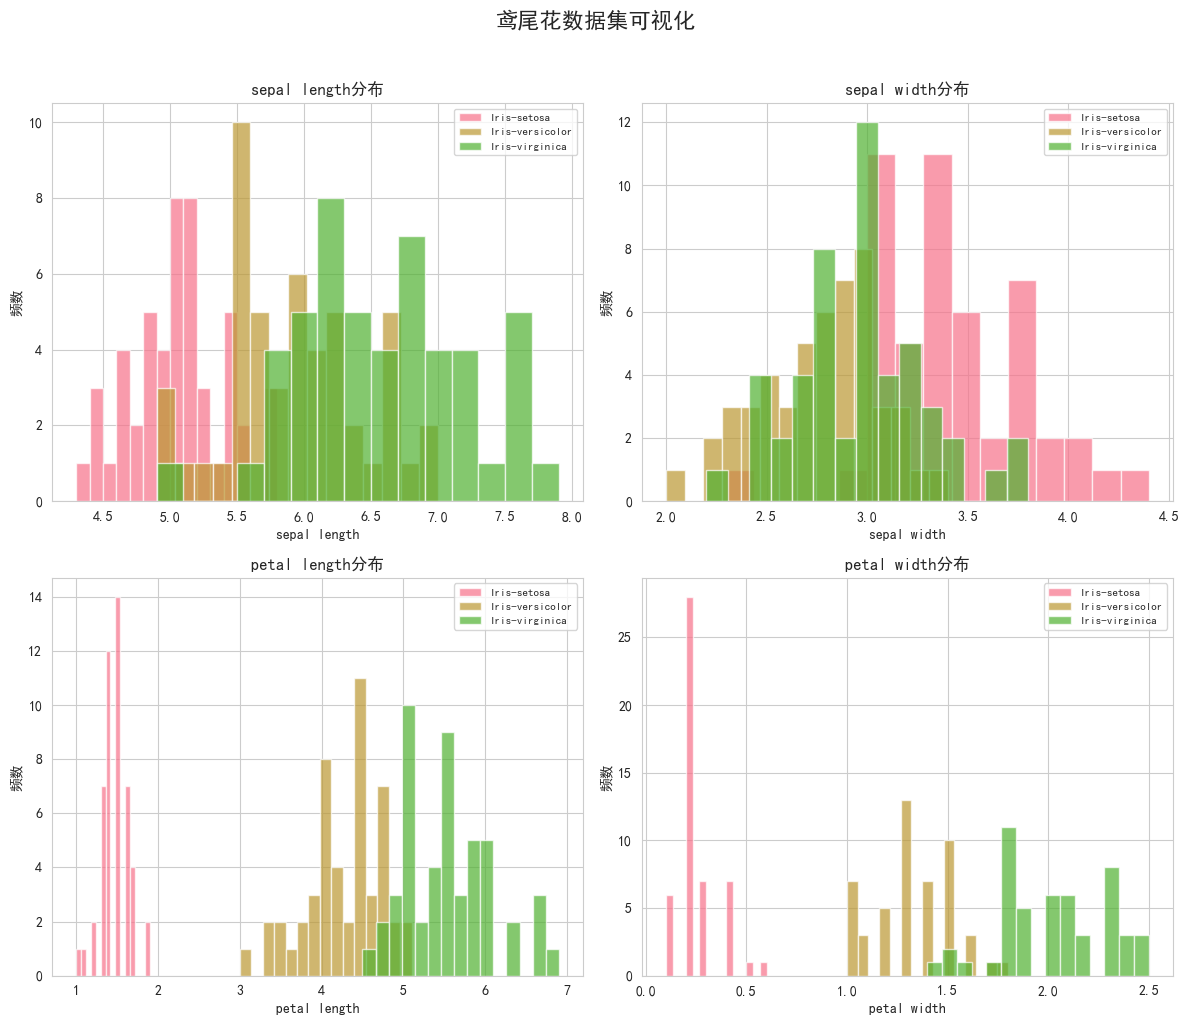

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

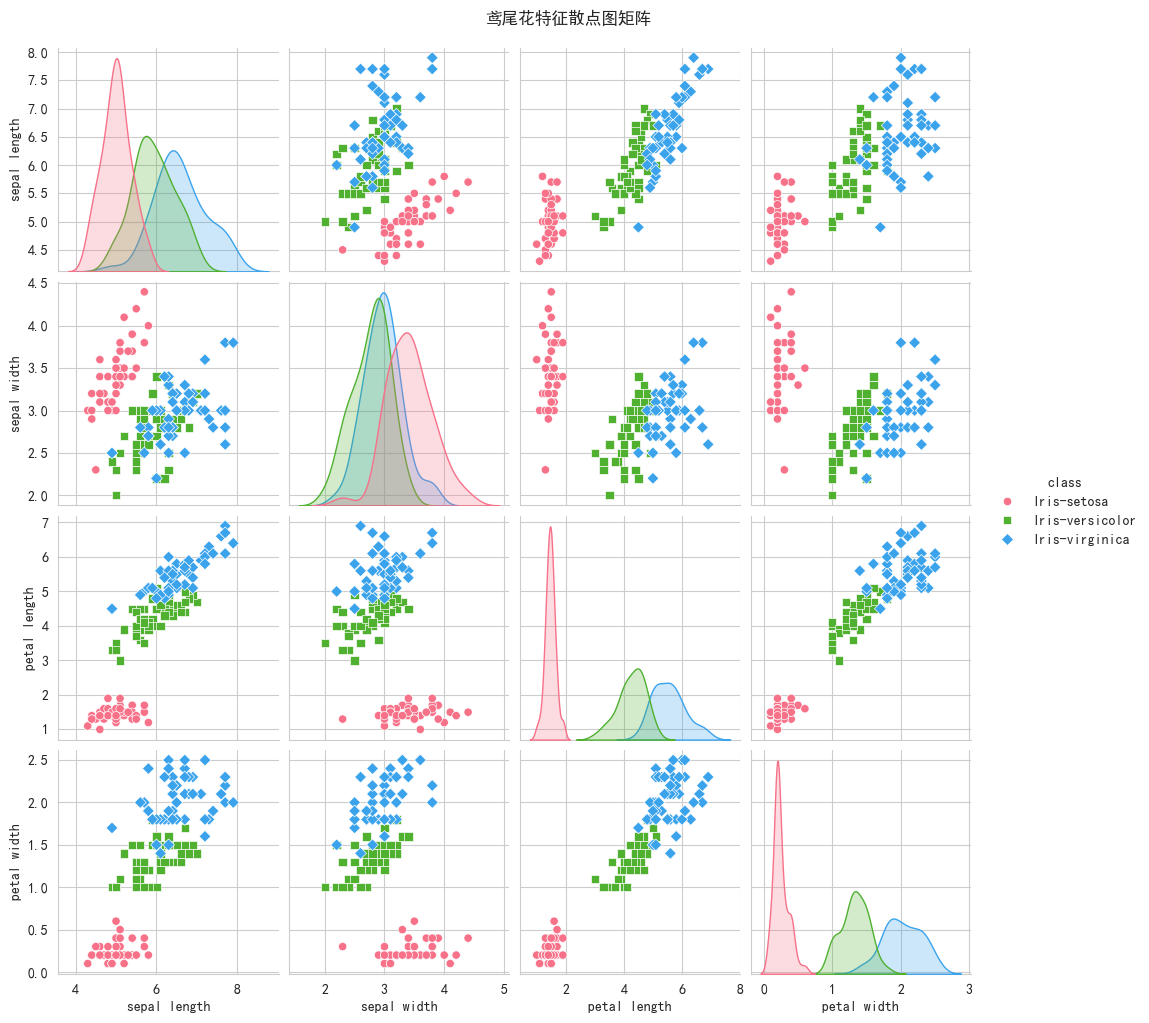

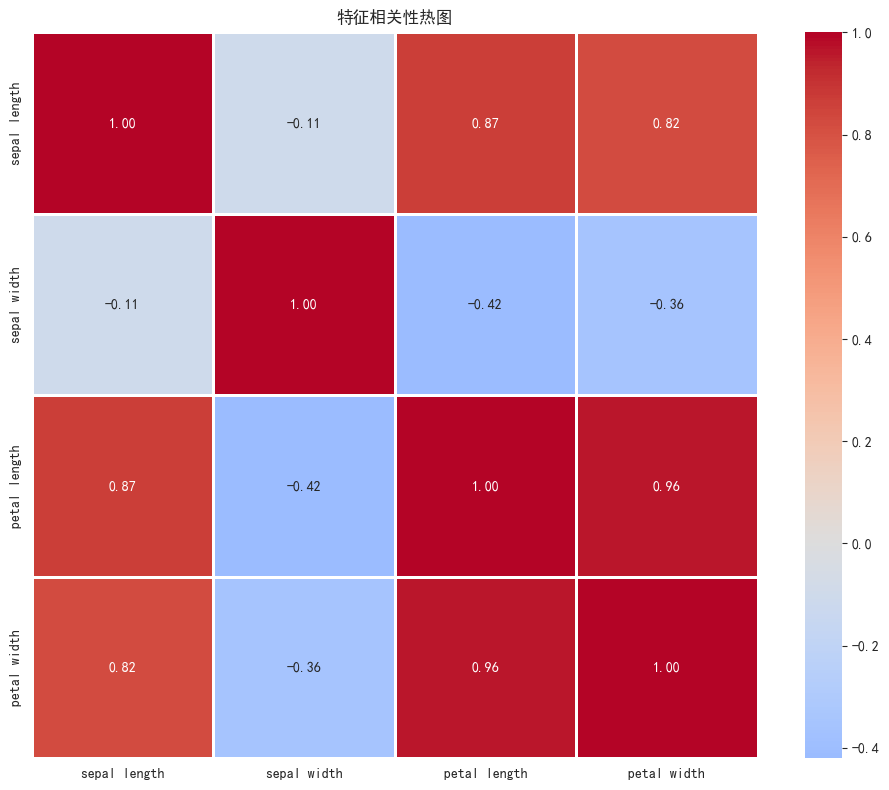

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('鸢尾花数据集可视化', fontsize=16, y=1.02)

# 将axes展平为一维数组
axes = axes.flatten()

# 1. 特征分布直方图
for idx, feature in enumerate(X.columns):
    ax = axes[idx]  # 直接使用索引
    for class_idx, class_name in enumerate(class_names):
        class_mask = y_encoded == class_idx
        ax.hist(X[feature][class_mask], alpha=0.7, label=class_name, bins=15)
    ax.set_xlabel(feature)
    ax.set_ylabel('频数')
    ax.legend(fontsize=8)
    ax.set_title(f'{feature}分布')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

# %%
# 散点图矩阵
df_plot = X.copy()
df_plot['class'] = y['class']

plt.figure(figsize=(12, 10))
sns.pairplot(df_plot, hue='class', palette='husl', markers=['o', 's', 'D'])
plt.suptitle('鸢尾花特征散点图矩阵', y=1.02)
plt.show()

# %%
# 相关性热图
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=1, square=True)
plt.title('特征相关性热图')
plt.tight_layout()
plt.show()


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report)
import time

# 定义TensorFlow神经网络模型
def create_tf_nn_model(input_dim, num_classes):
    """创建TensorFlow神经网络模型"""
    model_seq = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model_seq.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model_seq

# 定义模型列表（先定义其他模型，神经网络稍后单独处理）
models = {
    '逻辑回归': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
    '支持向量机': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True),
    '随机森林': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'K近邻': KNeighborsClassifier(n_neighbors=5)
}

# 存储结果的字典
results = {
    '模型名称': [],
    '训练时间': [],
    '预测时间': [],
    '训练准确率': [],
    '测试准确率': [],
    '精确率(macro)': [],
    '召回率(macro)': [],
    'F1分数(macro)': []
}

# 存储模型对象和预测结果
trained_models = {}
predictions = {}


In [15]:
for model_name, model in models.items():
    print(f"\n正在训练 {model_name}...")
    print("-" * 40)
    
    # 记录训练时间
    train_start = time.time()
    model.fit(X_train_scaled, y_train)
    train_end = time.time()
    train_time = train_end - train_start
    
    # 记录预测时间
    pred_start = time.time()
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    pred_end = time.time()
    pred_time = pred_end - pred_start
    
    # 计算评估指标
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='macro')
    recall = recall_score(y_test, y_test_pred, average='macro')
    f1 = f1_score(y_test, y_test_pred, average='macro')
    
    # 存储结果
    results['模型名称'].append(model_name)
    results['训练时间'].append(train_time)
    results['预测时间'].append(pred_time)
    results['训练准确率'].append(train_acc)
    results['测试准确率'].append(test_acc)
    results['精确率(macro)'].append(precision)
    results['召回率(macro)'].append(recall)
    results['F1分数(macro)'].append(f1)
    
    # 存储模型和预测
    trained_models[model_name] = model
    predictions[model_name] = y_test_pred
    
    print(f"训练时间: {train_time:.4f}秒")
    print(f"预测时间: {pred_time:.4f}秒")
    print(f"训练准确率: {train_acc:.4f}")
    print(f"测试准确率: {test_acc:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"F1分数: {f1:.4f}")

# 现在训练TensorFlow神经网络
print(f"\n正在训练 TensorFlow神经网络...")
print("-" * 40)

# 创建模型
tf_model = create_tf_nn_model(X_train_scaled.shape[1], num_classes)

# 设置早停
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=0
)

# 记录训练时间
train_start = time.time()

# 训练模型
history = tf_model.fit(
    X_train_scaled, 
    y_train_categorical,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

train_end = time.time()
train_time = train_end - train_start

# 记录预测时间
pred_start = time.time()
# 训练集预测
y_train_pred_proba = tf_model.predict(X_train_scaled, verbose=0)
y_train_pred = np.argmax(y_train_pred_proba, axis=1)
# 测试集预测
y_test_pred_proba = tf_model.predict(X_test_scaled, verbose=0)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)
pred_end = time.time()
pred_time = pred_end - pred_start

# 计算评估指标
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

# 存储结果
results['模型名称'].append('TensorFlow神经网络')
results['训练时间'].append(train_time)
results['预测时间'].append(pred_time)
results['训练准确率'].append(train_acc)
results['测试准确率'].append(test_acc)
results['精确率(macro)'].append(precision)
results['召回率(macro)'].append(recall)
results['F1分数(macro)'].append(f1)

# 存储模型和预测
trained_models['TensorFlow神经网络'] = tf_model
predictions['TensorFlow神经网络'] = y_test_pred

print(f"训练时间: {train_time:.4f}秒")
print(f"预测时间: {pred_time:.4f}秒")
print(f"训练轮数: {len(history.history['loss'])}")
print(f"最终训练损失: {history.history['loss'][-1]:.4f}")
print(f"最终验证损失: {history.history['val_loss'][-1]:.4f}")
print(f"训练准确率: {train_acc:.4f}")
print(f"测试准确率: {test_acc:.4f}")
print(f"精确率: {precision:.4f}")
print(f"召回率: {recall:.4f}")
print(f"F1分数: {f1:.4f}")



正在训练 逻辑回归...
----------------------------------------
训练时间: 0.0061秒
预测时间: 0.0000秒
训练准确率: 0.9810
测试准确率: 0.9111
精确率: 0.9155
召回率: 0.9111
F1分数: 0.9107

正在训练 支持向量机...
----------------------------------------
训练时间: 0.0029秒
预测时间: 0.0010秒
训练准确率: 0.9714
测试准确率: 0.9333
精确率: 0.9345
召回率: 0.9333
F1分数: 0.9333

正在训练 随机森林...
----------------------------------------
训练时间: 0.0964秒
预测时间: 0.0120秒
训练准确率: 1.0000
测试准确率: 0.8889
精确率: 0.8981
召回率: 0.8889
F1分数: 0.8878

正在训练 XGBoost...
----------------------------------------
训练时间: 0.0342秒
预测时间: 0.0010秒
训练准确率: 1.0000
测试准确率: 0.9333
精确率: 0.9345
召回率: 0.9333
F1分数: 0.9333

正在训练 K近邻...
----------------------------------------
训练时间: 0.0000秒
预测时间: 0.0113秒
训练准确率: 0.9810
测试准确率: 0.9111
精确率: 0.9298
召回率: 0.9111
F1分数: 0.9095

正在训练 TensorFlow神经网络...
----------------------------------------
训练时间: 9.0492秒
预测时间: 0.1508秒
训练轮数: 200
最终训练损失: 0.0317
最终验证损失: 0.0154
训练准确率: 0.9905
测试准确率: 0.9111
精确率: 0.9155
召回率: 0.9111
F1分数: 0.9107


模型性能综合比较表:
          模型名称     训练时间     预测时间    训练准确率    测试准确率  精确率(macro)  召回率(macro)  F1分数(macro)
         支持向量机 0.002916 0.001001 0.971429 0.933333    0.934524    0.933333     0.933259
       XGBoost 0.034231 0.001000 1.000000 0.933333    0.934524    0.933333     0.933259
          逻辑回归 0.006054 0.000000 0.980952 0.911111    0.915535    0.911111     0.910714
           K近邻 0.000000 0.011350 0.980952 0.911111    0.929825    0.911111     0.909502
TensorFlow神经网络 9.049235 0.150771 0.990476 0.911111    0.915535    0.911111     0.910714
          随机森林 0.096389 0.011999 1.000000 0.888889    0.898148    0.888889     0.887767


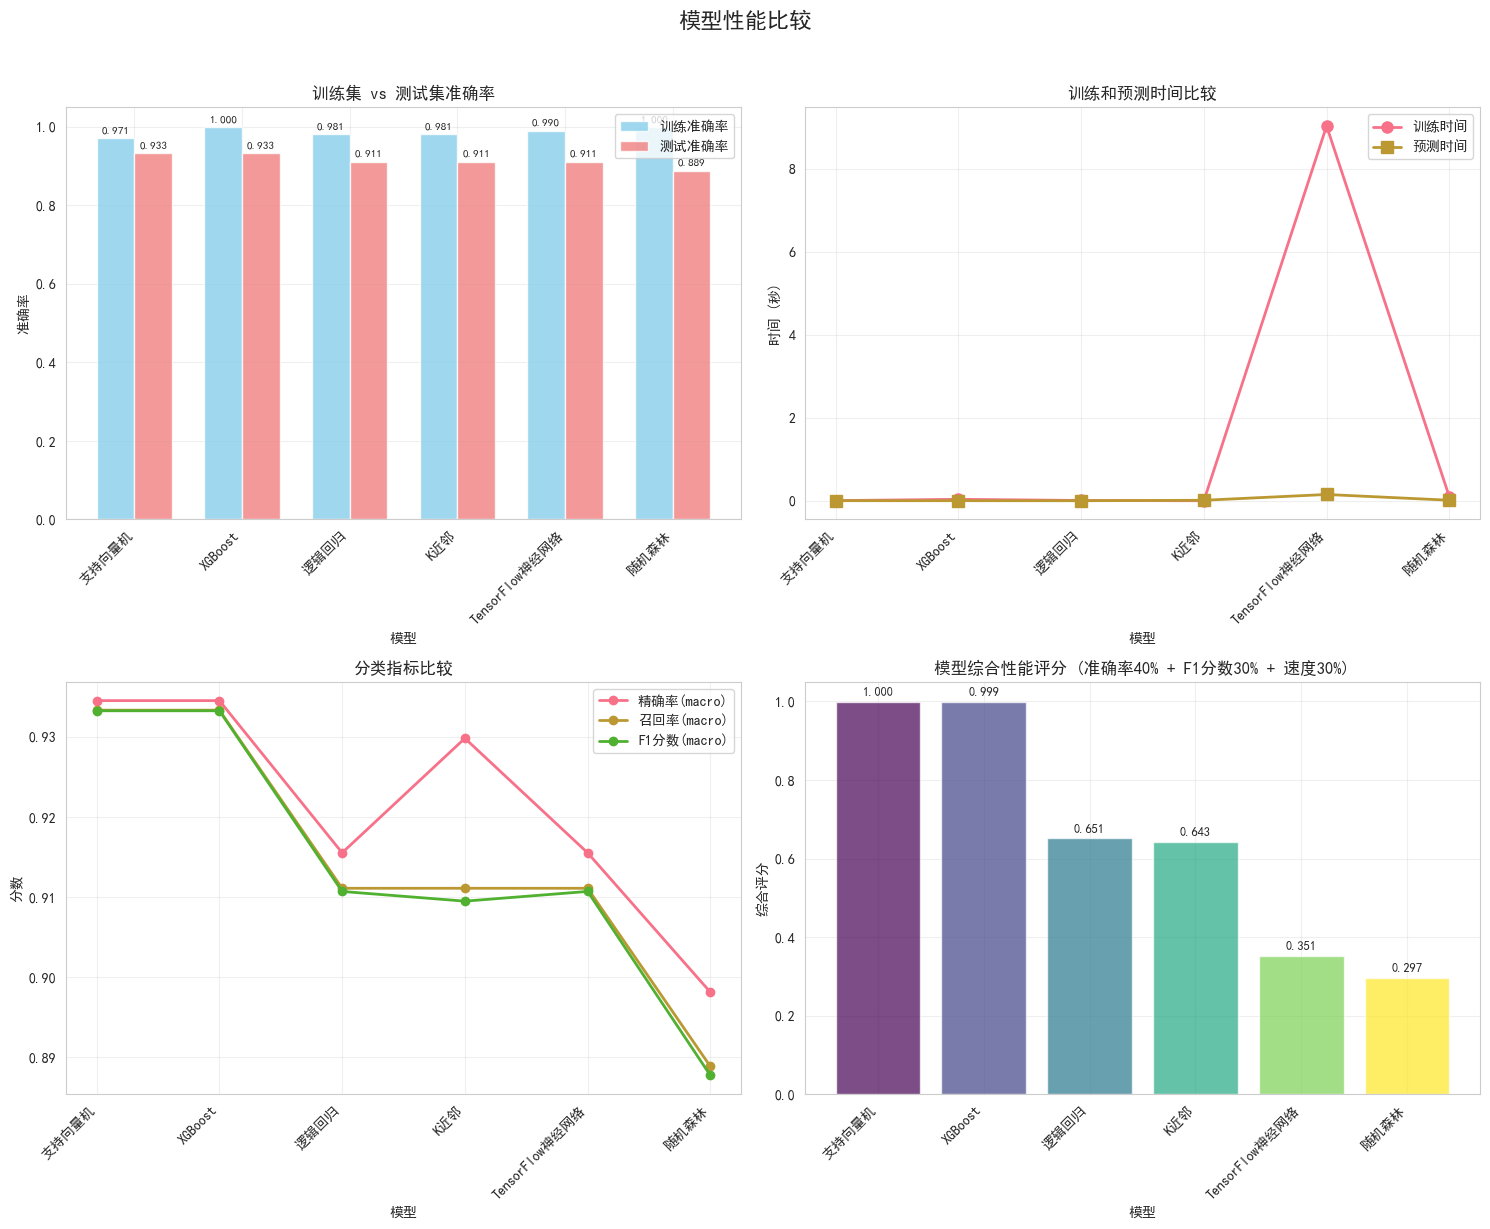


模型综合评分表 (按评分排序):
          模型名称    测试准确率  F1分数(macro)     训练时间     综合评分
         支持向量机 0.933333     0.933259 0.002916 0.999903
       XGBoost 0.933333     0.933259 0.034231 0.998865
          逻辑回归 0.911111     0.910714 0.006054 0.651128
           K近邻 0.911111     0.909502 0.000000 0.643336
TensorFlow神经网络 0.911111     0.910714 9.049235 0.351328
          随机森林 0.888889     0.887767 0.096389 0.296805


In [16]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('测试准确率', ascending=False)

print("="*80)
print("模型性能综合比较表:")
print("="*80)
print(results_df.to_string(index=False))

# %%
# 可视化比较
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('模型性能比较', fontsize=16, y=1.02)

# 1. 准确率比较
ax1 = axes[0, 0]
models_ordered = results_df['模型名称'].tolist()
train_acc_ordered = [results_df[results_df['模型名称']==m]['训练准确率'].values[0] for m in models_ordered]
test_acc_ordered = [results_df[results_df['模型名称']==m]['测试准确率'].values[0] for m in models_ordered]

x = np.arange(len(models_ordered))
width = 0.35
ax1.bar(x - width/2, train_acc_ordered, width, label='训练准确率', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, test_acc_ordered, width, label='测试准确率', alpha=0.8, color='lightcoral')
ax1.set_xlabel('模型')
ax1.set_ylabel('准确率')
ax1.set_title('训练集 vs 测试集准确率')
ax1.set_xticks(x)
ax1.set_xticklabels(models_ordered, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 在柱子上添加数值
for i, (train, test) in enumerate(zip(train_acc_ordered, test_acc_ordered)):
    ax1.text(i - width/2, train + 0.01, f'{train:.3f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i + width/2, test + 0.01, f'{test:.3f}', ha='center', va='bottom', fontsize=8)

# 2. 训练和预测时间比较
ax2 = axes[0, 1]
train_times = [results_df[results_df['模型名称']==m]['训练时间'].values[0] for m in models_ordered]
pred_times = [results_df[results_df['模型名称']==m]['预测时间'].values[0] for m in models_ordered]

x = np.arange(len(models_ordered))
ax2.plot(x, train_times, 'o-', label='训练时间', linewidth=2, markersize=8)
ax2.plot(x, pred_times, 's-', label='预测时间', linewidth=2, markersize=8)
ax2.set_xlabel('模型')
ax2.set_ylabel('时间 (秒)')
ax2.set_title('训练和预测时间比较')
ax2.set_xticks(x)
ax2.set_xticklabels(models_ordered, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 精确率、召回率、F1分数比较
ax3 = axes[1, 0]
metrics = ['精确率(macro)', '召回率(macro)', 'F1分数(macro)']
for metric in metrics:
    values = [results_df[results_df['模型名称']==m][metric].values[0] for m in models_ordered]
    ax3.plot(x, values, 'o-', label=metric, linewidth=2, markersize=6)
    
ax3.set_xlabel('模型')
ax3.set_ylabel('分数')
ax3.set_title('分类指标比较')
ax3.set_xticks(x)
ax3.set_xticklabels(models_ordered, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 综合评分柱状图
ax4 = axes[1, 1]
# 计算综合评分（加权平均）
normalized_acc = (results_df['测试准确率'] - results_df['测试准确率'].min()) / (results_df['测试准确率'].max() - results_df['测试准确率'].min())
normalized_f1 = (results_df['F1分数(macro)'] - results_df['F1分数(macro)'].min()) / (results_df['F1分数(macro)'].max() - results_df['F1分数(macro)'].min())
normalized_speed = 1 - (results_df['训练时间'] - results_df['训练时间'].min()) / (results_df['训练时间'].max() - results_df['训练时间'].min())

# 综合评分
composite_score = 0.4 * normalized_acc + 0.3 * normalized_f1 + 0.3 * normalized_speed
results_df['综合评分'] = composite_score

# 按综合评分排序
results_sorted = results_df.sort_values('综合评分', ascending=False)

x_pos = np.arange(len(results_sorted))
bars = ax4.bar(x_pos, results_sorted['综合评分'], alpha=0.7, color=plt.cm.viridis(np.linspace(0, 1, len(results_sorted))))

ax4.set_xlabel('模型')
ax4.set_ylabel('综合评分')
ax4.set_title('模型综合性能评分 (准确率40% + F1分数30% + 速度30%)')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(results_sorted['模型名称'], rotation=45, ha='right')
ax4.grid(True, alpha=0.3)

# 在柱子上添加数值
for bar, score in zip(bars, results_sorted['综合评分']):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 显示综合评分表
print("\n" + "="*80)
print("模型综合评分表 (按评分排序):")
print("="*80)
print(results_sorted[['模型名称', '测试准确率', 'F1分数(macro)', '训练时间', '综合评分']].to_string(index=False))


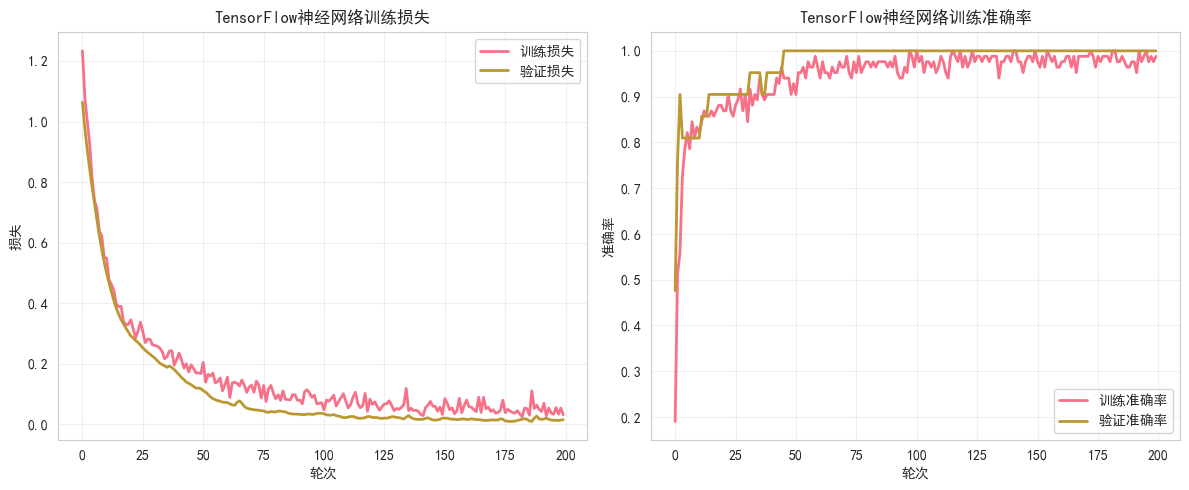

In [17]:
if 'TensorFlow神经网络' in trained_models:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 损失曲线
    ax1 = axes[0]
    ax1.plot(history.history['loss'], label='训练损失', linewidth=2)
    ax1.plot(history.history['val_loss'], label='验证损失', linewidth=2)
    ax1.set_xlabel('轮次')
    ax1.set_ylabel('损失')
    ax1.set_title('TensorFlow神经网络训练损失')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 准确率曲线
    ax2 = axes[1]
    ax2.plot(history.history['accuracy'], label='训练准确率', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='验证准确率', linewidth=2)
    ax2.set_xlabel('轮次')
    ax2.set_ylabel('准确率')
    ax2.set_title('TensorFlow神经网络训练准确率')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

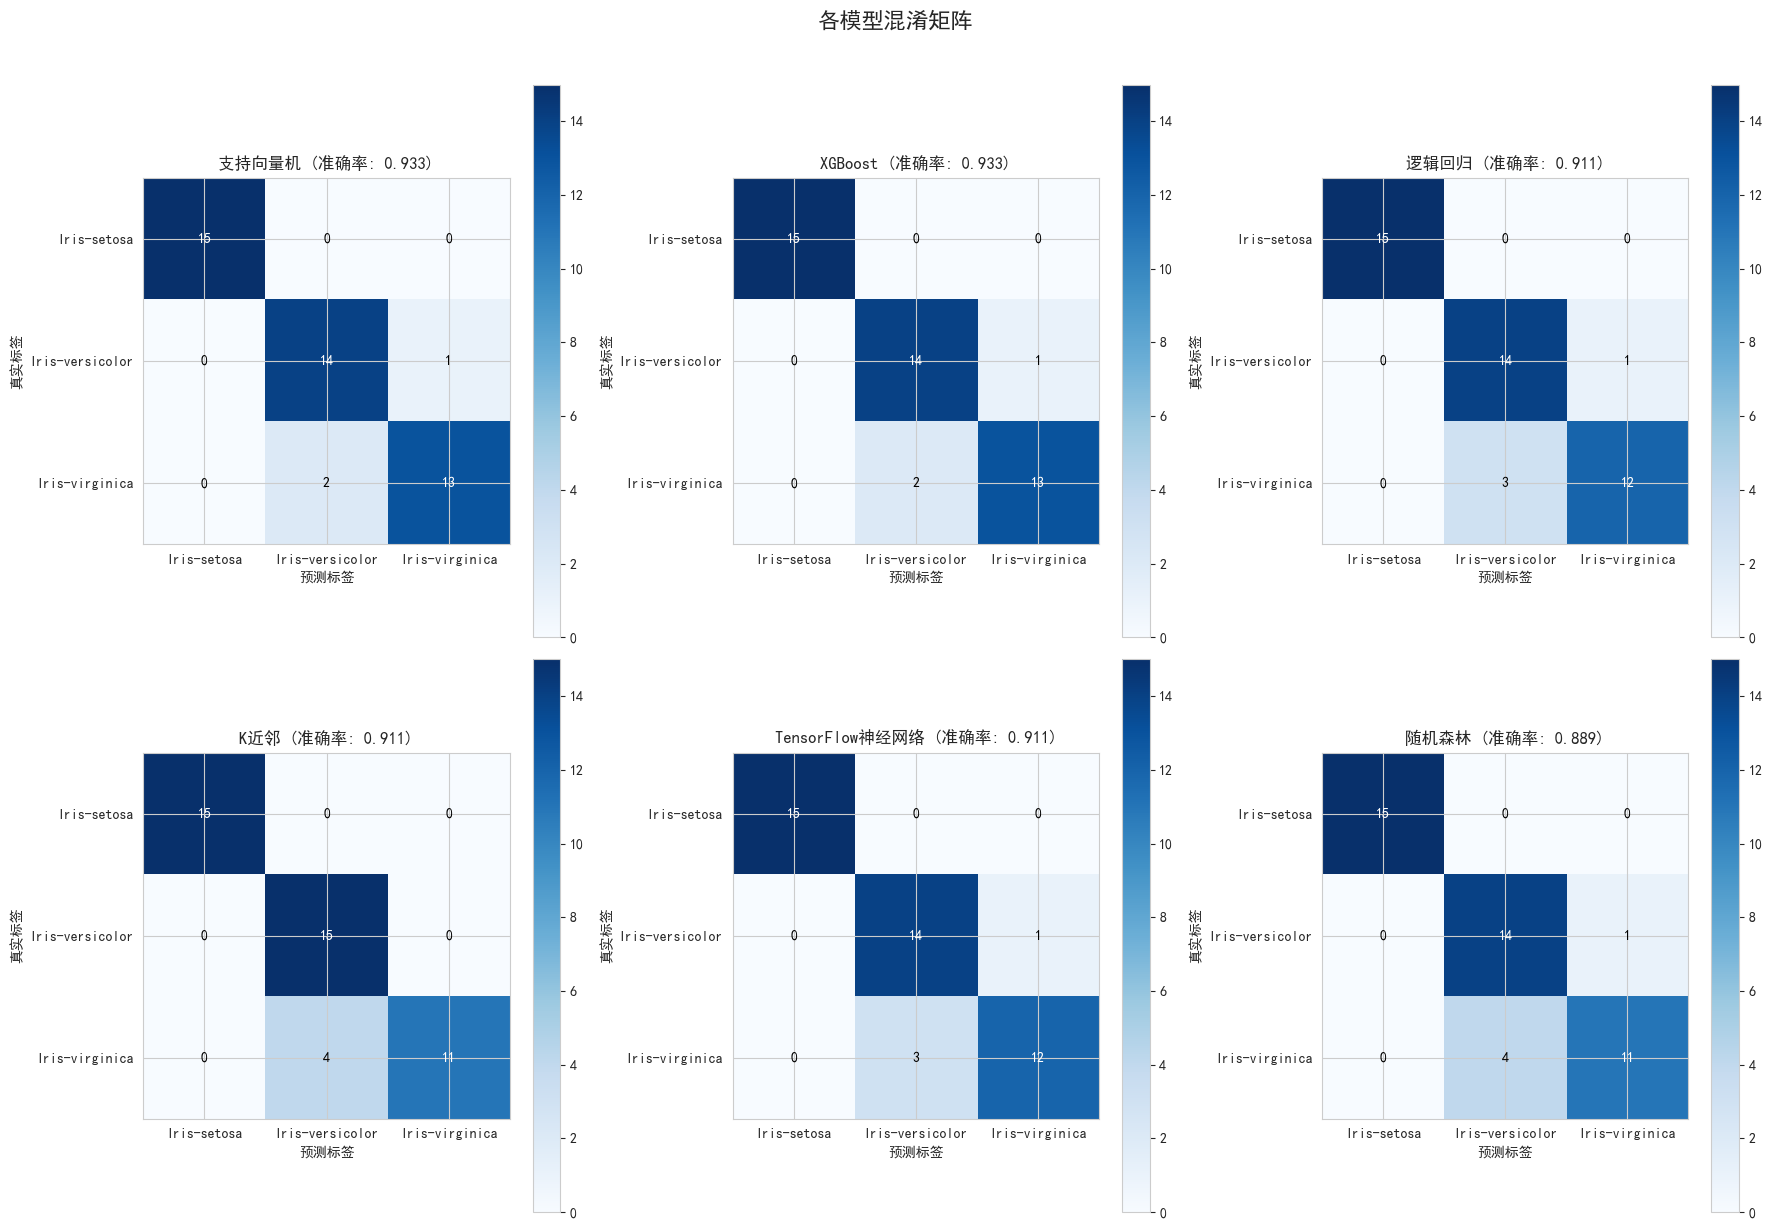

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('各模型混淆矩阵', fontsize=16, y=1.02)

axes = axes.flatten()

for idx, model_name in enumerate(models_ordered):
    ax = axes[idx]
    y_pred = predictions[model_name]
    cm = confusion_matrix(y_test, y_pred)
    
    # 创建热图
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # 添加文本标签
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")
    
    ax.set_xlabel('预测标签')
    ax.set_ylabel('真实标签')
    ax.set_title(f'{model_name} (准确率: {results_df[results_df["模型名称"]==model_name]["测试准确率"].values[0]:.3f})')
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

# 隐藏多余的子图
for idx in range(len(models_ordered), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

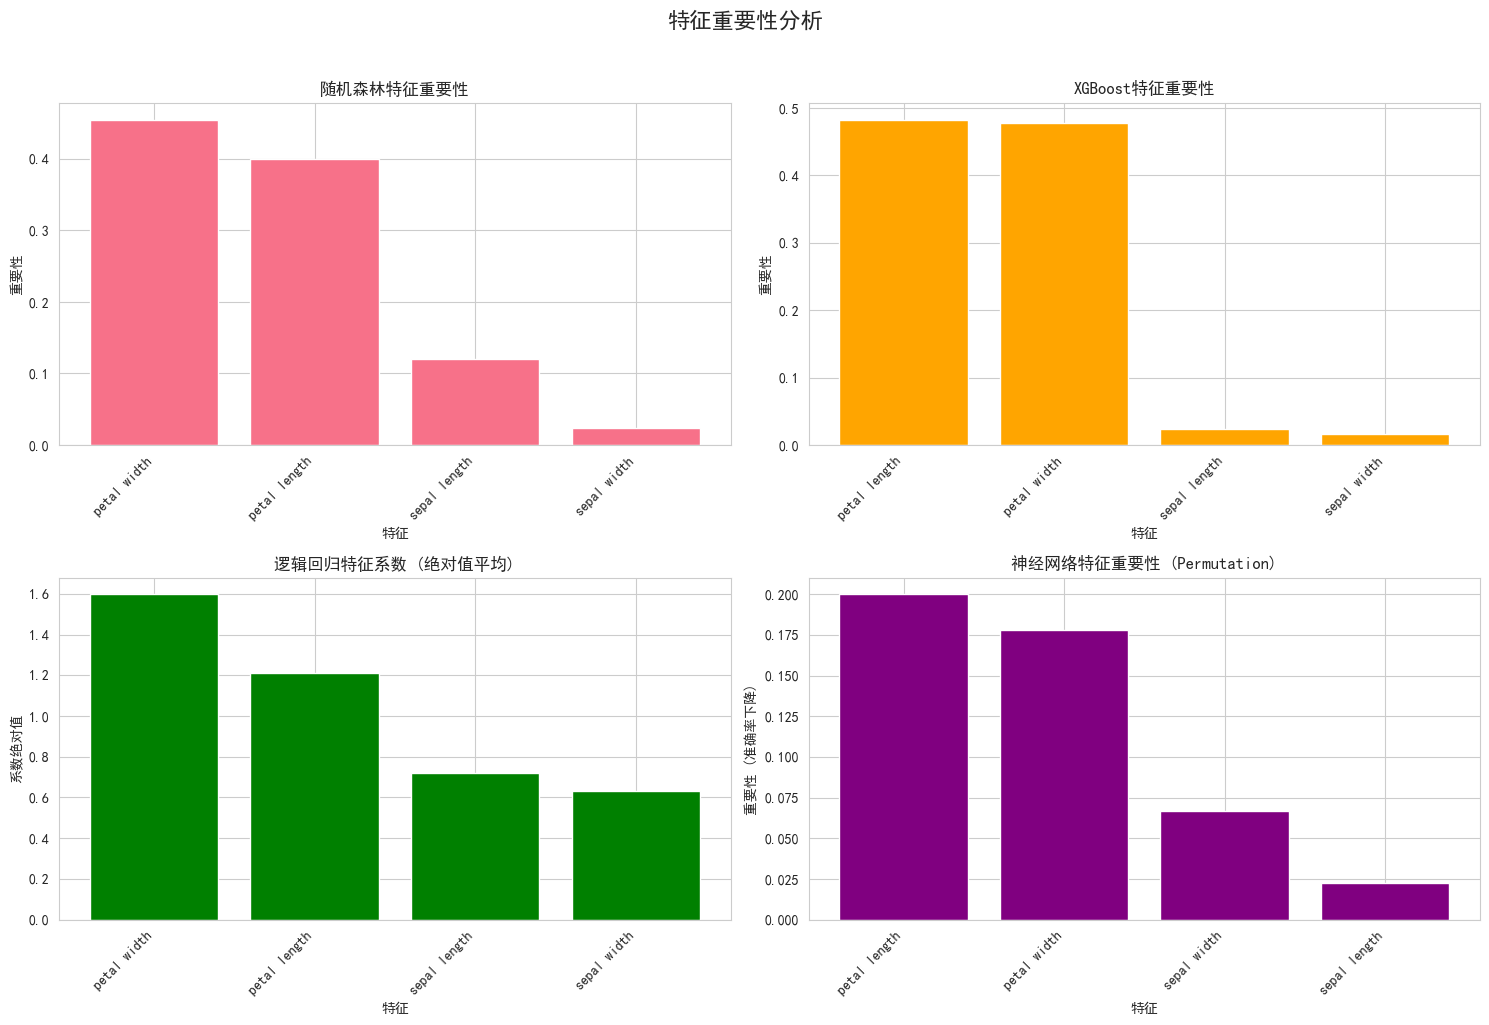

In [19]:
feature_names = X.columns.tolist()
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('特征重要性分析', fontsize=16, y=1.02)

axes = axes.flatten()

# 1. 随机森林特征重要性
if hasattr(trained_models['随机森林'], 'feature_importances_'):
    ax1 = axes[0]
    rf_importance = trained_models['随机森林'].feature_importances_
    indices = np.argsort(rf_importance)[::-1]
    
    ax1.bar(range(len(feature_names)), rf_importance[indices])
    ax1.set_xlabel('特征')
    ax1.set_ylabel('重要性')
    ax1.set_title('随机森林特征重要性')
    ax1.set_xticks(range(len(feature_names)))
    ax1.set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')

# 2. XGBoost特征重要性
if hasattr(trained_models['XGBoost'], 'feature_importances_'):
    ax2 = axes[1]
    xgb_importance = trained_models['XGBoost'].feature_importances_
    indices = np.argsort(xgb_importance)[::-1]
    
    ax2.bar(range(len(feature_names)), xgb_importance[indices], color='orange')
    ax2.set_xlabel('特征')
    ax2.set_ylabel('重要性')
    ax2.set_title('XGBoost特征重要性')
    ax2.set_xticks(range(len(feature_names)))
    ax2.set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')

# 3. 逻辑回归特征系数（绝对值）
if hasattr(trained_models['逻辑回归'], 'coef_'):
    ax3 = axes[2]
    # 对于多分类，取平均系数
    lr_coef = np.mean(np.abs(trained_models['逻辑回归'].coef_), axis=0)
    indices = np.argsort(lr_coef)[::-1]
    
    ax3.bar(range(len(feature_names)), lr_coef[indices], color='green')
    ax3.set_xlabel('特征')
    ax3.set_ylabel('系数绝对值')
    ax3.set_title('逻辑回归特征系数 (绝对值平均)')
    ax3.set_xticks(range(len(feature_names)))
    ax3.set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')

# 4. 神经网络特征重要性（使用permutation importance）
ax4 = axes[3]

# 为神经网络计算一个简单的特征重要性
# 这里我们使用模型对每个特征的敏感度作为重要性指标
if 'TensorFlow神经网络' in trained_models:
    # 获取原始预测准确率作为基准
    baseline_pred = trained_models['TensorFlow神经网络'].predict(X_test_scaled, verbose=0)
    baseline_pred_classes = np.argmax(baseline_pred, axis=1)
    baseline_acc = accuracy_score(y_test, baseline_pred_classes)
    
    feature_importance = []
    for i in range(X_test_scaled.shape[1]):
        # 复制测试集
        X_test_perturbed = X_test_scaled.copy()
        # 打乱第i个特征
        np.random.shuffle(X_test_perturbed[:, i])
        # 重新预测
        perturbed_pred = trained_models['TensorFlow神经网络'].predict(X_test_perturbed, verbose=0)
        perturbed_pred_classes = np.argmax(perturbed_pred, axis=1)
        perturbed_acc = accuracy_score(y_test, perturbed_pred_classes)
        # 重要性 = 准确率下降
        importance = baseline_acc - perturbed_acc
        feature_importance.append(max(importance, 0))
    
    indices = np.argsort(feature_importance)[::-1]
    ax4.bar(range(len(feature_names)), [feature_importance[i] for i in indices], color='purple')
    ax4.set_xlabel('特征')
    ax4.set_ylabel('重要性 (准确率下降)')
    ax4.set_title('神经网络特征重要性 (Permutation)')
    ax4.set_xticks(range(len(feature_names)))
    ax4.set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')

plt.tight_layout()
plt.show()


进行5折交叉验证...
逻辑回归: 0.9810 (±0.0233)
支持向量机: 0.9714 (±0.0233)
随机森林: 0.9524 (±0.0301)
XGBoost: 0.9524 (±0.0426)
K近邻: 0.9524 (±0.0426)
TensorFlow神经网络: 0.9867 (±0.0047)


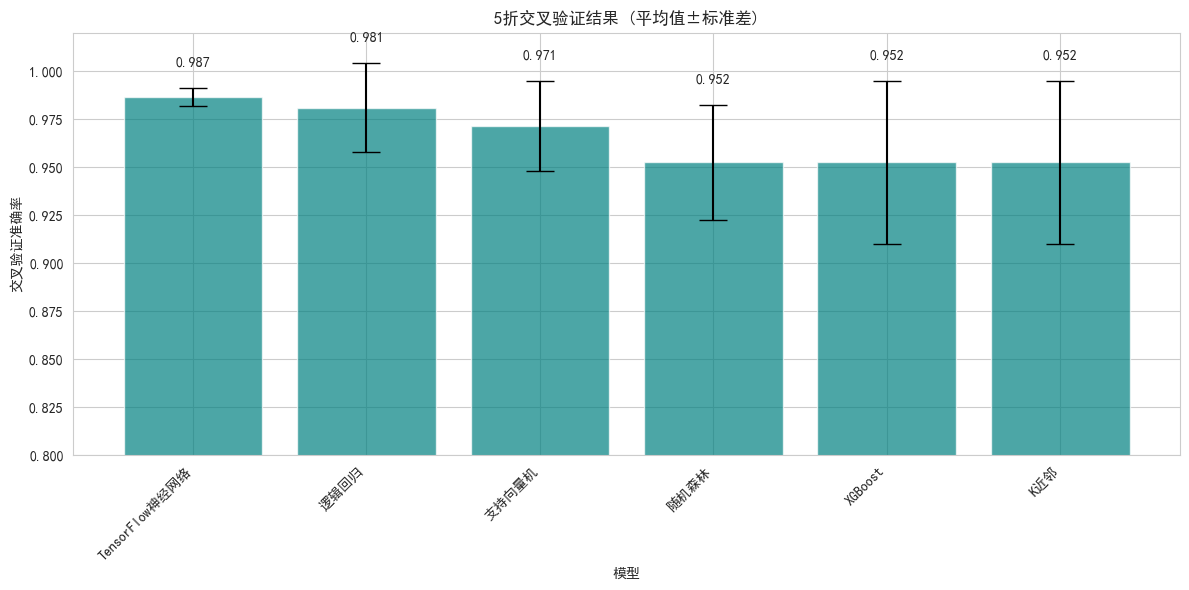

In [21]:
from sklearn.model_selection import cross_val_score

print("进行5折交叉验证...")
print("="*80)

cv_results = {}
# 对传统模型进行交叉验证
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_results[model_name] = {
        '平均准确率': cv_scores.mean(),
        '标准差': cv_scores.std(),
        '分数范围': f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}"
    }
    print(f"{model_name}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# 对神经网络进行手动交叉验证
tf_cv_scores = []
for i in range(5):  # 5折交叉验证
    # 创建新的模型实例
    temp_model = create_tf_nn_model(X_train_scaled.shape[1], num_classes)
    temp_model.fit(X_train_scaled, y_train_categorical, 
                   epochs=100, batch_size=16, verbose=0)
    # 评估
    y_pred_proba = temp_model.predict(X_train_scaled, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    score = accuracy_score(y_train, y_pred)
    tf_cv_scores.append(score)

cv_results['TensorFlow神经网络'] = {
    '平均准确率': np.mean(tf_cv_scores),
    '标准差': np.std(tf_cv_scores),
    '分数范围': f"{np.mean(tf_cv_scores):.3f} ± {np.std(tf_cv_scores):.3f}"
}
print(f"TensorFlow神经网络: {np.mean(tf_cv_scores):.4f} (±{np.std(tf_cv_scores):.4f})")

# 可视化交叉验证结果
cv_df = pd.DataFrame(cv_results).T
cv_df = cv_df.sort_values('平均准确率', ascending=False)

plt.figure(figsize=(12, 6))
x_pos = np.arange(len(cv_df))
plt.bar(x_pos, cv_df['平均准确率'], yerr=cv_df['标准差'], 
        capsize=10, alpha=0.7, color='teal')
plt.xlabel('模型')
plt.ylabel('交叉验证准确率')
plt.title('5折交叉验证结果 (平均值±标准差)')
plt.xticks(x_pos, cv_df.index, rotation=45, ha='right')
plt.ylim([0.8, 1.02])

# 添加数值标签
for i, (mean, std) in enumerate(zip(cv_df['平均准确率'], cv_df['标准差'])):
    plt.text(i, mean + std + 0.01, f'{mean:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [24]:
best_model_row = results_df.loc[results_df['测试准确率'].idxmax()]
best_model_name = best_model_row['模型名称']
best_accuracy = best_model_row['测试准确率']

print(f" 最佳模型: {best_model_name}")
print(f" 测试准确率: {best_accuracy:.4f}")
print(f" 训练时间: {best_model_row['训练时间']:.4f}秒")

print("\n 模型性能分类:")
print("-"*40)

# 按准确率分类
high_acc = results_df[results_df['测试准确率'] >= 0.95]
medium_acc = results_df[(results_df['测试准确率'] >= 0.90) & (results_df['测试准确率'] < 0.95)]
low_acc = results_df[results_df['测试准确率'] < 0.90]

print(f"高准确率模型 (>0.95):")
for _, row in high_acc.iterrows():
    print(f"  - {row['模型名称']}: {row['测试准确率']:.4f}")

if not medium_acc.empty:
    print(f"\n中等准确率模型 (0.90-0.95):")
    for _, row in medium_acc.iterrows():
        print(f"  - {row['模型名称']}: {row['测试准确率']:.4f}")

if not low_acc.empty:
    print(f"\n较低准确率模型 (<0.90):")
    for _, row in low_acc.iterrows():
        print(f"  - {row['模型名称']}: {row['测试准确率']:.4f}")

print("\n 效率分析:")
print("-"*40)

# 找出最快和最慢的模型
fastest_model = results_df.loc[results_df['训练时间'].idxmin()]
slowest_model = results_df.loc[results_df['训练时间'].idxmax()]

print(f"最快训练模型: {fastest_model['模型名称']} ({fastest_model['训练时间']:.4f}秒)")
print(f"最慢训练模型: {slowest_model['模型名称']} ({slowest_model['训练时间']:.4f}秒)")

print("\n 推荐建议:")
print("-"*40)

# 基于准确率和效率的推荐
balanced_models = results_df[
    (results_df['测试准确率'] >= results_df['测试准确率'].quantile(0.75)) & 
    (results_df['训练时间'] <= results_df['训练时间'].quantile(0.5))
]

if not balanced_models.empty:
    print("推荐平衡型模型 (高准确率且训练速度快):")
    for _, row in balanced_models.iterrows():
        print(f"  - {row['模型名称']}: 准确率={row['测试准确率']:.4f}, 训练时间={row['训练时间']:.4f}秒")
else:
    print("推荐高准确率模型:")
    for _, row in high_acc.head(3).iterrows():
        print(f"  - {row['模型名称']}: 准确率={row['测试准确率']:.4f}, 训练时间={row['训练时间']:.4f}秒")


 最佳模型: 支持向量机
 测试准确率: 0.9333
 训练时间: 0.0029秒

 模型性能分类:
----------------------------------------
高准确率模型 (>0.95):

中等准确率模型 (0.90-0.95):
  - 支持向量机: 0.9333
  - XGBoost: 0.9333
  - 逻辑回归: 0.9111
  - K近邻: 0.9111
  - TensorFlow神经网络: 0.9111

较低准确率模型 (<0.90):
  - 随机森林: 0.8889

 效率分析:
----------------------------------------
最快训练模型: K近邻 (0.0000秒)
最慢训练模型: TensorFlow神经网络 (9.0492秒)

 推荐建议:
----------------------------------------
推荐平衡型模型 (高准确率且训练速度快):
  - 支持向量机: 准确率=0.9333, 训练时间=0.0029秒
